In [1]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=1e-10, which="LM", return_eigenvectors=False
                )
                '''print('energy:')
                print(energy)
                print('Direct Diagonalisation:')
                print(spi.linalg.eigvals(H_eff.toarray()))
                print('sparce f:')
                print(vals[np.argmin(np.abs(vals))]'''
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)

    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    '''print('f(0):')
    print(min_eigenvalue(0))
    print('f(1e-16)')
    print(min_eigenvalue(1e-16))
    print('f(3e-16)')
    print(min_eigenvalue(3e-16))
    print('f(1e-15)')
    print(min_eigenvalue(1e-15))'''
    
    '''print('f(0):')
    print(min_eigenvalue(0.))'''
    
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    candidates = []
    for a, b in intervals:
        try:
            if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
                candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
                candidates.append(candidate)
        except RuntimeError: #some problems with lead modes
            continue
    
    '''f_E = []
    for e in energies:
        f_E.append(min_eigenvalue(e))
    plt.scatter(energies, f_E)'''
    
    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=1e-10, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


In [2]:
import kwant
import tinyarray
import numpy as np
import scipy as spi

import matplotlib.pyplot as plt 
import matplotlib.colors as colors

In [3]:
## function for phase-on-delta implementation

#infinite implementation (transparency changed to mismatched chemical potential)

def make_system_disorder(W=10, t=1.5, nu=2., mu=0., U_0=1., delta=1., B=2., phi=0, salt='chizhang'):
    a = 1
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))
    
    
    #### Define onsite and hopping ####
    def onsite(site):
        return (2.*t-mu-U_0*kwant.digest.gauss(repr(site), repr(salt)))*tau_z + B*tau_z@sigma_x
    
    #### Define the scattering region. ####
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    syst[(lat(W+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    
    syst[(lat(x) for x in range(1, W+1))] = onsite
    
    syst[(lat(0), lat(1))] = -spi.linalg.expm(1j*phi*tau_z/2.)@(t*tau_z + 1j*nu*tau_z@sigma_y)
    if W>0:
        syst[((lat(x), lat(x+1)) for x in range(1, W+1))] = -t*tau_z - 1j*nu*tau_z@sigma_y
    
    '''syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(-L_s, 1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    syst[(lat(L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(L+1, L+2+L_s))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    #syst[((lat(x), lat(x+1)) for x in range(-L_s, 0))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    #syst[((lat(x), lat(x+1)) for x in range(L+1, L+1+L_s))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y'''
    
    #### Define callable methods ####
    def plot_mu():
        site_array = np.arange(0, W+2)
        mu_array.append(mu)
        plt.plot(site_array, mu_array)
        plt.xlabel('sites')
        plt.ylabel(r'$\mu$')
        
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead0[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(W+2))] =  (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead1[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [4]:
## function for phase-on-delta implementation

#infinite implementation (transparency changed to mismatched chemical potential)

def make_system_mu(W=10, t=1, nu=0.5, mu=0.5, mu_lead0=0.5, mu_lead1=0.5, delta=0.5, B=1, phi=0):
    a = 1
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))
    
    #### Define the scattering region. ####
    syst[(lat(0))] = (2.*t-mu_lead0)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    syst[(lat(W+1))] = (2.*t-mu_lead1)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    
    syst[(lat(x) for x in range(1, W+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    
    syst[(lat(0), lat(1))] = -spi.linalg.expm(1j*phi*tau_z/2.)@(t*tau_z + 1j*nu*tau_z@sigma_y)
    if W>0:
        syst[((lat(x), lat(x+1)) for x in range(1, W+1))] = -t*tau_z - 1j*nu*tau_z@sigma_y
    
    '''syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(-L_s, 1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    syst[(lat(L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(L+1, L+2+L_s))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    #syst[((lat(x), lat(x+1)) for x in range(-L_s, 0))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    #syst[((lat(x), lat(x+1)) for x in range(L+1, L+1+L_s))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y'''
    
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu_lead0)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead0[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(W+2))] =  (2.*t-mu_lead1)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead1[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [5]:
def mu_profile(syst, t=1.5):
    ham = syst.hamiltonian_submatrix()
    mu_array = []
    for i in range(0, ham.shape[0], 4):
        mu_array.append(np.real(2.*t-ham[i][i]))
    return np.array(mu_array)

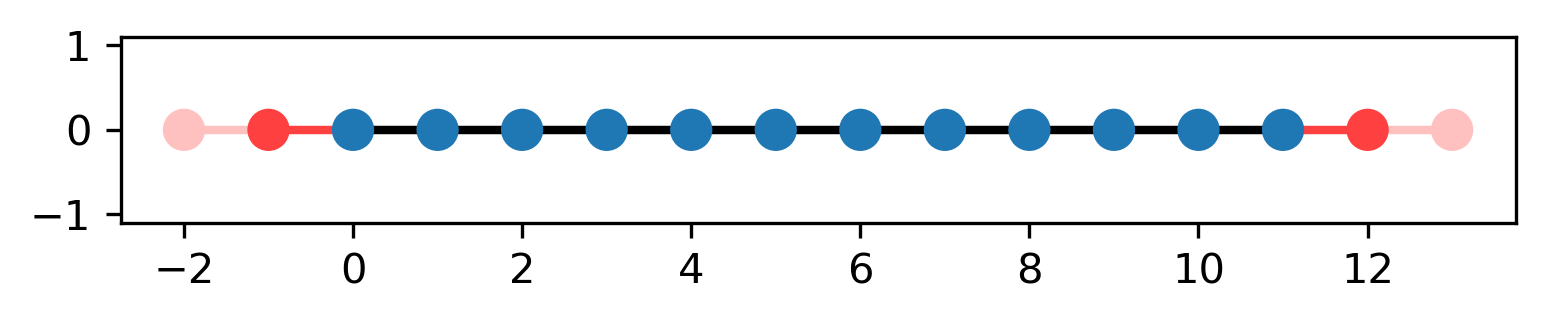

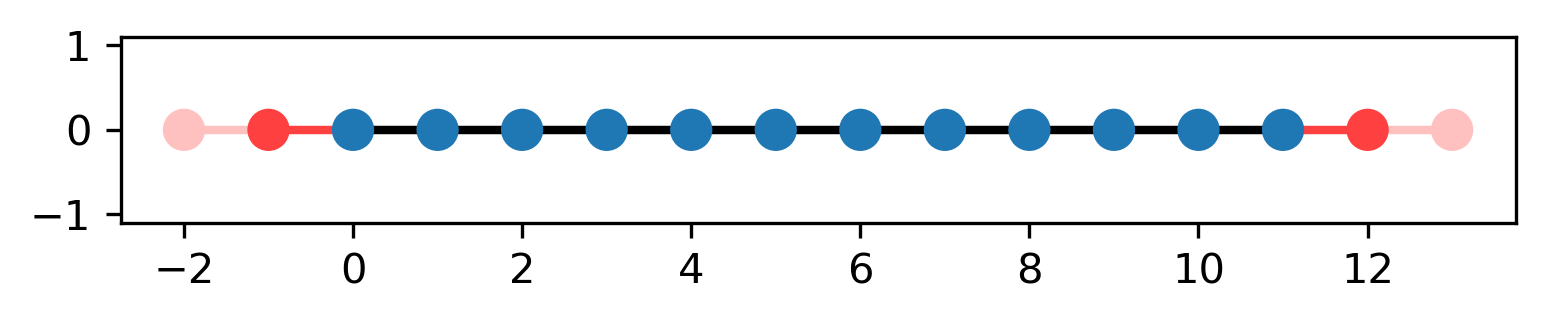

In [6]:
kwant.plot(make_system_disorder(W=10, salt='chizhang', U_0=0.), dpi=300)

[Text(0.5, 0, 'Site indices'), Text(0, 0.5, '$\\mu$')]

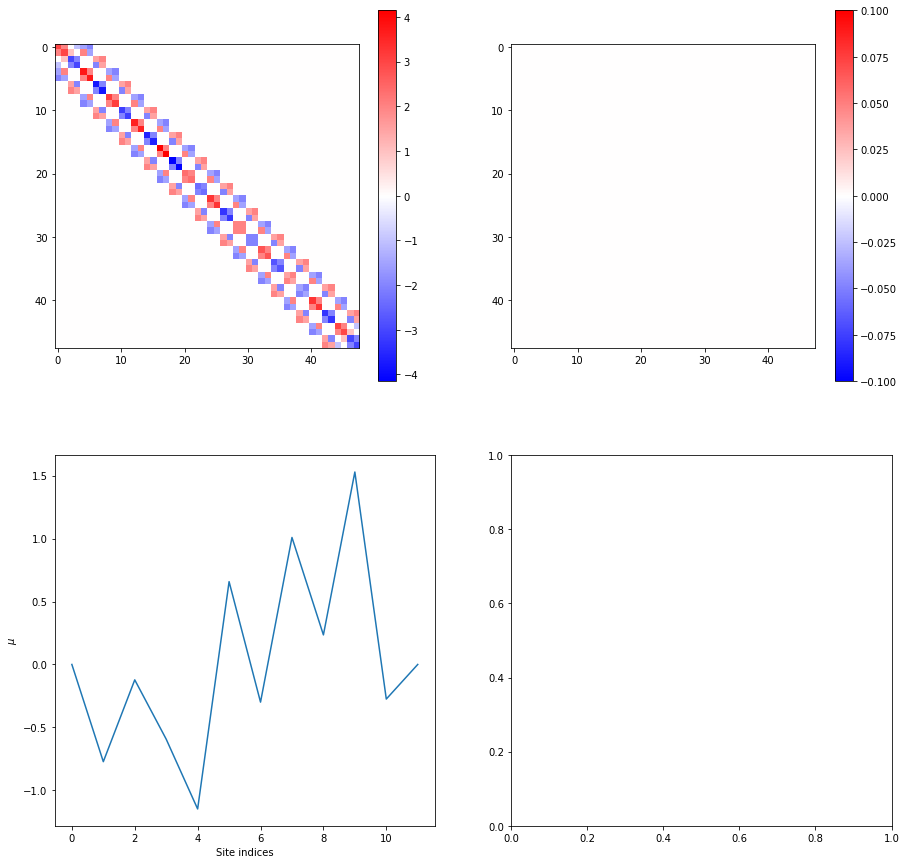

In [7]:
syst = make_system_disorder(W=10, salt='chizhang', U_0=1.)
ham_bdg = syst.hamiltonian_submatrix()

norm1 = colors.TwoSlopeNorm(vcenter=0)
norm2 = colors.TwoSlopeNorm(vcenter=0)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
im1 = ax1.imshow(np.real(ham_bdg), cmap='bwr', interpolation='none', norm=norm1)
fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(np.imag(ham_bdg), cmap='bwr', interpolation='none', norm=norm2)
fig.colorbar(im2, ax=ax2)
im3 = ax3.plot(np.arange(0, 12), mu_profile(syst))
ax3.set(xlabel='Site indices', ylabel=r'$\mu$')

In [8]:
def U0_gap_scan(W=10, B=2., t=1.5, nu=2., mu=0., delta=1., U0_array=[0, 5], phi=np.pi, salt='chizhang', mode='gauss'):
    energy_arrays=[]
    wavefunc_arrays=[]
    if mode=='gauss':
        for i in np.linspace(U0_array[0], U0_array[1], 51):
            print(i)
            syst = make_system_disorder(W=W, B=B, t=t, nu=nu, mu=mu, U_0=i, delta=delta, phi=phi, salt=salt)
            energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
            energy_arrays.append(energies)
            wavefunc_arrays.append(wavefunctions)
            print(energies)
    elif mode=='uniform':
        for i in np.linspace(U0_array[0], U0_array[1], 51):
            print(i)
            syst = make_system_uni_disorder(W=W, B=B, t=t, nu=nu, mu=mu, U_0=i, delta=delta, phi=phi, salt=salt)
            energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
            energy_arrays.append(energies)
            wavefunc_arrays.append(wavefunctions)
            print(energies)
    else:
        print('mode must be either "uniform" or "gauss"!')
    return energy_arrays, wavefunc_arrays

In [9]:
def B_scan(W=0, B_array=[0, 5e-3], t=1.5, nu=2., mu=0., delta=1e-3, U_0=0., phi=0., salt='chizhang', mode='gauss'):
    energy_arrays=[]
    wavefunc_arrays=[]
    if mode=='gauss':
        for i in np.arange(B_array[0], B_array[1], 0.1):
            print(i)
            syst = make_system_disorder(W=W, B=i, t=t, nu=nu, mu=mu, U_0=U_0, delta=delta, phi=phi, salt=salt)
            energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
            energy_arrays.append(energies)
            wavefunc_arrays.append(wavefunctions)
            print(energies)
    elif mode=='uniform':
        for i in np.arange(B_array[0], B_array[1], 0.1):
            print(i)
            syst = make_system_uni_disorder(W=W, B=i, t=t, nu=nu, mu=mu, U_0=U_0, delta=delta, phi=phi, salt=salt)
            energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
            energy_arrays.append(energies)
            wavefunc_arrays.append(wavefunctions)
            print(energies)
    else:
        print('mode must be either "uniform" or "gauss"!')
    return energy_arrays, wavefunc_arrays

In [10]:
def B_W_scan_pi(W=[0, 1, 2, 4, 10], B_array=[0, 6.1], t=1.5, nu=2., mu=0., delta=1., U_0=0., phi=np.pi, salt='chizhang', mode='gauss'):
    energy_arrays=[]
    wavefunc_arrays=[]
    for i in W:
        energy_subarray=[]
        wavefunc_subarray=[]
        for j in np.arange(B_array[0], B_array[1], 0.1):
            print(j)
            syst = make_system_disorder(W=i, B=j, t=t, nu=nu, mu=mu, U_0=U_0, delta=delta, phi=phi, salt=salt)
            energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
            energy_subarray.append(energies)
            wavefunc_subarray.append(wavefunctions)
            print(energies)
        energy_arrays.append(energy_subarray)
        wavefunc_arrays.append(wavefunc_subarray)
    return energy_arrays, wavefunc_arrays

In [11]:
def B_gap_scan(W=0, B_array=[0, 5e-3], t=1.5, nu=2., mu=0., delta=1e-3, U_0=0., phi=0., salt='chizhang', mode='gauss'):
    band_gap_array = []
    for i in np.arange(B_array[0], B_array[1], 0.1):
        print(i)
        syst = make_system_disorder(W=W, B=i, t=t, nu=nu, mu=mu, U_0=U_0, delta=delta, phi=phi, salt=salt)
        bands=kwant.physics.Bands(syst.leads[1])
        momenta=np.linspace(-np.pi,np.pi,100001)
        energies=[bands(k) for k in momenta]
        x=np.array(energies)
        en=(x)
        band_gap_array.append([np.min(en[:,2]), np.max(en[:,1])])
        print(np.min(en[:,2]))
    return np.array(band_gap_array)

In [12]:
def delta_scan(W=1, B_mul=[0, 2, 4], t=1.5, nu=2., mu=0., log_delta=np.linspace(-4, 0, 101), U_0=0., phi=0., salt='chizhang', mode='gauss'):
    energy_arrays=[]
    wavefunc_arrays=[]
    if mode=='gauss':
        for i in log_delta:
            print('delta=')
            delta = 10.**i
            print(delta)
            e_delta_array = []
            psi_delta_array = []
            for j in B_mul:
                print('B=')
                B = j*delta
                print(B)
                syst = make_system_disorder(W=W, B=B, t=t, nu=nu, mu=mu, U_0=U_0, delta=delta, phi=phi, salt=salt)
                energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
                e_delta_array.append(energies)
                psi_delta_array.append(wavefunctions)
                print(energies)
            energy_arrays.append(e_delta_array)
            wavefunc_arrays.append(psi_delta_array)
    elif mode=='uniform':
        for i in log_delta:
            print('delta=')
            delta = 10.**i
            print(delta)
            e_delta_array = []
            psi_delta_array = []
            for j in B_mul:
                print('B=')
                B = j*delta
                print(B)
                syst = make_system_uni_disorder(W=W, B=B, t=t, nu=nu, mu=mu, U_0=U_0, delta=delta, phi=phi, salt=salt)
                energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
                e_delta_array.append(energies)
                psi_delta_array.append(wavefunctions)
                print(energies)
            energy_arrays.append(e_delta_array)
            wavefunc_arrays.append(psi_delta_array)
    else:
        print('mode must be either "uniform" or "gauss"!')
    return energy_arrays, wavefunc_arrays

In [13]:
def mu_scan(W=10, B=2e-3, t=1.5, nu=2., mu_leads=0., delta=1e-3, phi=0., mu_array=[-5e-3, 5e-3]):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(mu_array[0], mu_array[1], 101):
        print(i)
        syst = make_system_mu(W=W, B=B, t=t, nu=nu, mu=i, mu_lead0=mu_leads, mu_lead1=mu_leads, delta=delta, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [14]:
def mu_alt_scan(W=10, B=2e-3, t=1.5, nu=2., mu_leads=0., delta=1e-3, phi=0., mu_array=[-5, 5]):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(mu_array[0], mu_array[1], 101):
        print(i)
        syst = make_system_mu(W=W, B=B, t=t, nu=nu, mu=i, mu_lead0=i, mu_lead1=i, delta=delta, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [15]:
def delta_gap_scan(W=1, B_mul=[0, 2, 4], t=1.5, nu=2., mu=0., log_delta=np.linspace(-4, 0, 101), U_0=0., phi=0., salt='chizhang', mode='gauss'):
    band_gap_array = []
    for i in B_mul:
        band_gap_B_array = []
        for j in log_delta:
            delta = 10.**j
            print('delta=')
            print(delta)
            B = i*delta
            print('B=')
            print(B)
            syst = make_system_disorder(W=W, B=B, t=t, nu=nu, mu=mu, U_0=U_0, delta=delta, phi=phi, salt=salt)
            bands=kwant.physics.Bands(syst.leads[1])
            momenta=np.linspace(-np.pi,np.pi,100001)
            energies=[bands(k) for k in momenta]
            x=np.array(energies)
            en=(x)
            band_gap_B_array.append([np.min(en[:,2]), np.max(en[:,1])])
            print('gap=')
            print(np.min(en[:,2]))
        band_gap_array.append(band_gap_B_array)
    return np.array(band_gap_array)

In [28]:
e_trial = delta_gap_scan(log_delta=np.linspace(-4, 0, 2))

delta=
0.0001
B=
0.0
gap=
0.0001
delta=
1.0
B=
0.0
gap=
1.0
delta=
0.0001
B=
0.0002
gap=
9.207333311541547e-05
delta=
1.0
B=
2.0
gap=
0.8787387398866731
delta=
0.0001
B=
0.0004
gap=
8.170116403447618e-05
delta=
1.0
B=
4.0
gap=
0.6019068065784614


In [31]:
print(e_trial[2])

[[ 8.17011640e-05 -8.17011640e-05]
 [ 6.01906807e-01 -6.01906807e-01]]


Band gap:
2.0000000012916743
Fermi momentum
0.9272724876335636
35242


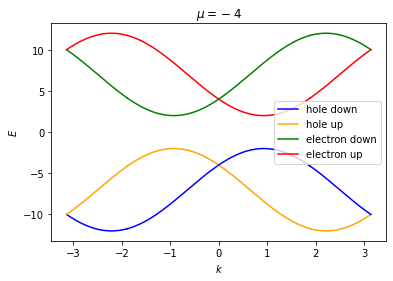

In [180]:
plt.rcParams.update({'font.size': 10})
mu=-2.
B=2.*np.sqrt(mu**2.+1.**2.)
syst = make_system_disorder(W=0, B=0., t=1.5, nu=2., mu=-4, U_0=0., delta=0., phi=0., salt='chizhang')
bands=kwant.physics.Bands(syst.leads[1])
momenta=np.linspace(-np.pi,np.pi,100001)
energies=[bands(k) for k in momenta]
x=np.array(energies)
en=(x)
print('Band gap:')
print(np.min(en[:,2]))
print('Fermi momentum')
print(np.abs(np.linspace(-np.pi,np.pi,100001)[np.argmin(en[:,2])]))
fermi_index = np.argmin(en[:,2])
print(fermi_index)
plt.plot(momenta[:int(len(momenta)-80022)], en[:int(len(momenta)-80022),0], color='blue', label='hole down')
plt.plot(momenta[:int(len(momenta)-80022)], en[:int(len(momenta)-80022),1], color='orange', label='hole up')
plt.plot(momenta[:int(len(momenta)-80022)], en[:int(len(momenta)-80022),2], color='green', label='electron down')
plt.plot(momenta[:int(len(momenta)-80022)], en[:int(len(momenta)-80022),3], color='red', label='electron up')
plt.plot(momenta[int(len(momenta)-80022):int(len(momenta)/2)], en[int(len(momenta)-80022):int(len(momenta)/2),0], color='blue')
plt.plot(momenta[int(len(momenta)-80022):int(len(momenta)/2)], en[int(len(momenta)-80022):int(len(momenta)/2),1], color='orange')
plt.plot(momenta[int(len(momenta)-80022):int(len(momenta)/2)], en[int(len(momenta)-80022):int(len(momenta)/2),2], color='green')
plt.plot(momenta[int(len(momenta)-80022):int(len(momenta)/2)], en[int(len(momenta)-80022):int(len(momenta)/2),3], color='red')
plt.plot(momenta[int(len(momenta)/2):80022], en[int(len(momenta)/2):80022,0], color='orange')
plt.plot(momenta[int(len(momenta)/2):80022], en[int(len(momenta)/2):80022,1], color='blue')
plt.plot(momenta[int(len(momenta)/2):80022], en[int(len(momenta)/2):80022,2], color='red')
plt.plot(momenta[int(len(momenta)/2):80022], en[int(len(momenta)/2):80022,3], color='green')
plt.plot(momenta[80022:], en[80022:,0], color='orange')
plt.plot(momenta[80022:], en[80022:,1], color='blue')
plt.plot(momenta[80022:], en[80022:,2], color='red')
plt.plot(momenta[80022:], en[80022:,3], color='green')
#plt.xlim(-1, 1)
#plt.ylim(-2, 2)
plt.xlabel(r'$k$')
plt.ylabel(r'$E$')
plt.title(r'$\mu=-4$')
gap_energy = np.min(en[:,2])
plt.legend()
plt.savefig('./Keselman5/trial_dispersion-4', dpi=300)
#print(bands(0.05))

In [141]:
en[0:int(len(momenta)/2)]

array([[-11.0124922 ,  -9.0124922 ,   9.0124922 ,  11.0124922 ],
       [-11.01249222,  -9.01249216,   9.01249216,  11.01249222],
       [-11.0124923 ,  -9.01249205,   9.01249205,  11.0124923 ],
       ...,
       [ -5.03112921,  -3.03112865,   3.03112865,   5.03112921],
       [ -5.03112902,  -3.03112877,   3.03112877,   5.03112902],
       [ -5.03112891,  -3.03112885,   3.03112885,   5.03112891]])

In [191]:
def min_fermi_k(B):
    syst = make_system_disorder(W=0, B=B, t=1.5, nu=2., mu=-2., U_0=0., delta=1., phi=0., salt='chizhang')
    bands=kwant.physics.Bands(syst.leads[1])
    momenta=np.linspace(-np.pi,np.pi,100001)
    energies=[bands(k) for k in momenta]
    x=np.array(energies)
    en=(x)
    return np.linspace(-np.pi,np.pi,100001)[np.argmin(en[:,2][0:49500])]

result = scipy.optimize.minimize_scalar(min_fermi_k)
print(result.x)

-5.81318119159003e-06


In [189]:
def double_square(x, y):
    return x**2.+y**2.

result = scipy.optimize.minimize(double_square, 0, 100)
print(result.x)

[0.]


In [95]:
def U0_plot(energy_array, figure_title, U0_range=[0, 5], delta=1., title=r'$W=10, B=2, t=1.5, \nu=2, \mu=0, \phi=\pi, \Delta=1, salt=chizhang$'):
    ex=[]
    ey=[]
    U0_array=np.linspace(U0_range[0], U0_range[1], 51)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(U0_array[i])
            ey.append(energy_array[i][j])
            
    ey = np.array(ey)/delta
    plt.scatter(ex, ey)
    plt.xlim(U0_range[0], U0_range[1])
    plt.xlabel(r'$U_0$')
    plt.ylabel(r'$E/\Delta$')
    plt.title(title)
    plt.savefig('./Keselman5/'+figure_title, dpi=300)

In [122]:
def B_gap_plot(energy_array, e_gap_array, figure_title, B_range=[0, 5e-3], delta=1e-3, Bc=1e-3, title=r'$W=0, U_0=0, t=1.5, \nu=2, \mu=0, \phi=0, \Delta=1e-3, salt=chizhang$'):
    ex=[]
    ey=[]
    B_array=np.linspace(B_range[0], B_range[1], 200)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(B_array[i])
            ey.append(energy_array[i][j])
        
    ex = np.array(ex)/Bc
    ey = np.array(ey)/delta
    plt.plot(np.arange(0, 8.1, 0.1)/Bc, e_gap_array/delta)
    plt.scatter(ex, ey, s=3)
    #plt.xlim(B_range[0], B_range[1])
    plt.xlabel(r'$B/B_C$')
    plt.ylabel(r'$E/\Delta$')
    plt.title(title)
    plt.savefig('./Keselman5/'+figure_title, dpi=300)

In [112]:
def B_plot(energy_array, figure_title, B_range=[0, 6.1], delta=1., Bc=1., title=r'$W=0, U_0=0, t=1.5, \nu=2, \mu=0, \phi=\pi, \Delta=1, salt=chizhang$'):
    ex=[]
    ey=[]
    B_array=np.arange(B_range[0], B_range[1], 0.1)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(B_array[i])
            ey.append(energy_array[i][j])
        
    ex = np.array(ex)/Bc
    ey = np.array(ey)/delta
    plt.scatter(ex, ey, s=3)
    #plt.xlim(B_range[0], B_range[1])
    plt.xlabel(r'$B/B_C$')
    plt.ylabel(r'$E/\Delta$')
    plt.title(title)
    plt.savefig('./Keselman5/'+figure_title, dpi=300)

In [87]:
def delta_gap_plot(energy_array, e_gap_array, figure_title, log_delta=np.linspace(-4, 0, 101), title=r'$W=1, U_0=0, t=1.5, \nu=2, \mu=0, \phi=0, B=0B_C, salt=chizhang$'):
    ex=[]
    ey=[]
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(log_delta[i])
            ey.append(energy_array[i][j])
        
    ex = np.array(ex)
    ey = np.array(ey)/(10.**ex)
    plt.plot(log_delta, e_gap_array[:,0]/(10.**log_delta))
    plt.plot(log_delta, e_gap_array[:,1]/(10.**log_delta))
    plt.scatter(ex, ey, s=5)
    #plt.xlim(B_range[0], B_range[1])
    plt.xlabel(r'$ln(\Delta)$')
    plt.ylabel(r'$E/\Delta$')
    plt.title(title)
    plt.savefig('./Keselman5/'+figure_title, dpi=300)

In [106]:
def mu_plot(energy_array, figure_title, mu_range=[-5e-3, 5e-3], delta=1e-3, title=r'$W=10, B=2e-3, t=1.5, \nu=2, \mu_{lead0}=0, \mu_{lead1}=0, \Delta=1e-3, \phi=0$'):
    ex = []
    ey = []
    mu_array = np.linspace(mu_range[0], mu_range[1], 101)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(mu_array[i])
            ey.append(energy_array[i][j])
           
    ey = np.array(ey)
    ey = ey/delta
    plt.scatter(ex, ey)
    #plt.scatter(ex1, ey1, label=r'$\tau = 2/3$')
    #plt.scatter(ex2, ey2, label=r'$\tau = 1/3$')
    plt.xlim(mu_range[0], mu_range[1])
    #plt.ylim(2*min(ey), 2*max(ey))
    plt.xlabel(r'$\mu_{scat}$')
    plt.ylabel(r'$E$')
    plt.title(title)
    plt.savefig('./Keselman5/'+figure_title, dpi=300)

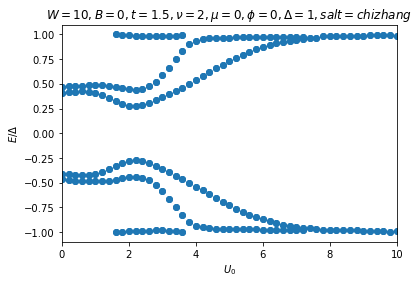

In [97]:
U0_plot(e_array7, 'U0_gap_scan(phi=0, U0_array=[0, 10], B=0)', U0_range=[0, 10], title=r'$W=10, B=0, t=1.5, \nu=2, \mu=0, \phi=0, \Delta=1, salt=chizhang$')

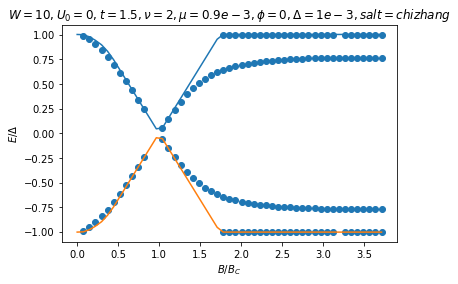

In [133]:
B_gap_plot(e_W10_array[17][0], e_B_gap_array[17], 'E vs B for small delta (mu=0p9e-3, W=10)', Bc=np.sqrt(1e-3**2.+0.9e-3**2), title=r'$W=10, U_0=0, t=1.5, \nu=2, \mu=0.9e-3, \phi=0, \Delta=1e-3, salt=chizhang$')

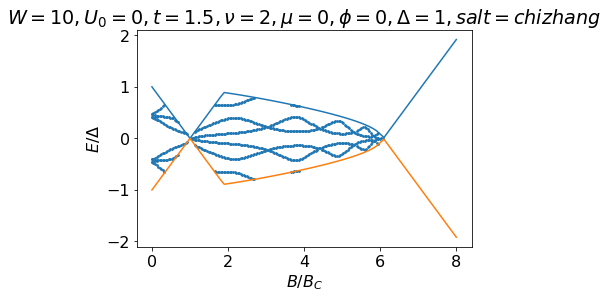

In [167]:
B_gap_plot(e_B_short_W_0[6], e_B_gap_long2, "B_scan (W=10) (gap1)", B_range=[0, 8], delta=1., Bc=1., title=r'$W=10, U_0=0, t=1.5, \nu=2, \mu=0, \phi=0, \Delta=1, salt=chizhang$')

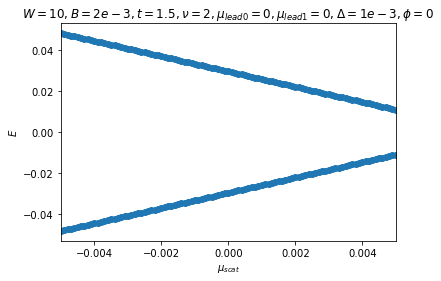

In [141]:
mu_plot(e_array18, 'mu_plot for small changes in mu_scat')

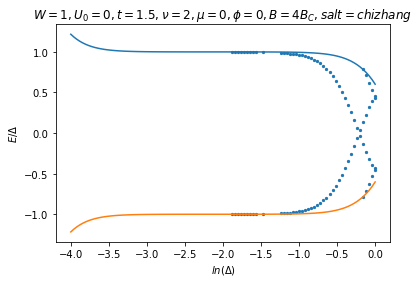

In [90]:
delta_gap_plot(eB3, e_delta_gap[2], 'delta_gap_scan(B=4Bc, W=1)', title=r'$W=1, U_0=0, t=1.5, \nu=2, \mu=0, \phi=0, B=4B_C, salt=chizhang$')

In [110]:
import pickle
pickle.dump(e_B_long_W_0, open('./Keselman5/Data/e_B_long_W_0', 'wb'))

In [ ]:
e_array, psi_array = U0_gap_scan(phi=0)

In [ ]:
e_array1, psi_array1 = U0_gap_scan(B=0., phi=0)

In [ ]:
e_array2, psi_array2 = U0_gap_scan(phi=0, salt='13')

In [ ]:
e_B_gap = B_gap_scan()

In [ ]:
e_array3, psi_array3 = B_scan()

In [ ]:
e_array3W, psi_array3W = B_scan(W=1)

In [ ]:
e_array3W2, psi_array3W2 = B_scan(W=2)

In [ ]:
e_array3W10, psi_array3W10 = B_scan(W=10)

In [ ]:
e_B_gap1 = B_gap_scan(mu=1e-3)

In [ ]:
e_array4, psi_array4 = B_scan(mu=1e-3)

In [ ]:
e_array4W, psi_array4W = B_scan(mu=1e-3, W=1)

In [ ]:
e_array4W2, psi_array4W2 = B_scan(mu=1e-3, W=2)

In [ ]:
e_array4W10, psi_array4W10 = B_scan(mu=1e-3, W=10)

In [ ]:
e_B_gap2 = B_gap_scan(mu=-1e-3)

In [ ]:
e_array5, psi_array5 = B_scan(mu=-1e-3)

In [ ]:
e_array5W, psi_arrayW = B_scan(mu=-1e-3, W=1)

In [ ]:
e_array5W2, psi_array5W2 = B_scan(mu=-1e-3, W=2)

In [ ]:
e_array5W10, psi_array5W10 = B_scan(mu=-1e-3, W=10)

In [ ]:
e_array6, psi_array6 = U0_gap_scan(U0_array=[0, 10], phi=0.)

In [ ]:
e_array7, psi_array7 = U0_gap_scan(U0_array=[0, 10], phi=0., B=0.)

In [ ]:
e_B_gap3 = B_gap_scan(mu=5e-3, delta=5e-3, B_array=[0, 20e-3*np.sqrt(2)])

In [ ]:
e_array12, psi_array12 = B_scan(mu=5e-3, delta=5e-3, B_array=[0, 20e-3*np.sqrt(2)])

In [ ]:
e_array16W10, psi_array16W10 = B_scan(mu=-0.9e-3, W=10)

In [ ]:
e_B_gap3 = B_gap_scan(mu=-0.9e-3)

In [ ]:
e_W10_array= []
e_B_gap_array = []
for i in np.linspace(-0.8e-3, 0.9e-3, 18):
    temp_array = B_scan(mu=i, W=10)
    temp_gap = B_gap_scan(mu=i)
    e_W10_array.append(temp_array)
    e_B_gap_array.append(temp_gap)

In [ ]:
e_W10_array_large_mu= []
e_B_gap_array_large_mu = []
for i in np.linspace(-1, 1, 21):
    temp_array = B_scan(mu=i, W=10, B_array=[0, 5])
    temp_gap = B_gap_scan(mu=i, B_range=[0, 5])
    e_W10_array.append(temp_array)
    e_B_gap_array.append(temp_gap)

In [ ]:
for i in np.linspace(-1, 1, 21):
    print(i)

In [ ]:
e_array17, psi_array17 = mu_scan()

In [ ]:
e_array18, psi_array18 = mu_alt_scan()

In [ ]:
e_B_test_array, psi_B_test_array = B_scan(W=2, mu=0, t=1.5, delta=1., nu=2., B_array=[0, 6.1])

In [ ]:
e_B_W_pi, psi_B_W_pi = B_W_scan_pi()

In [ ]:
e_B_long_W_0, psi_B_long_W_0 = B_W_scan_pi(W=[50, 51, 52, 53, 54, 55, 56], B_array=[0, 6.1], t=1.5, nu=2., mu=0., delta=1., U_0=0., phi=0., salt='chizhang', mode='gauss')

In [85]:
e_B_long_W_0 = pickle.load(open('./Keselman5/Data/e_B_long_W_0', 'rb'))

In [110]:
e_B_short_W_0 = pickle.load(open('./Keselman5/Data/Keselman_vary_B_vasileios', 'rb'))

In [94]:
e_B_gap_long = B_gap_scan(B_array=[0, 6.1], t=1.5, nu=2., mu=0., delta=1., U_0=0., phi=0., salt='chizhang', mode='gauss')

0.0
1.0
0.1
0.8999999999999999
0.2
0.8
0.30000000000000004
0.7000000000000002
0.4
0.5999999999999996
0.5
0.5
0.6000000000000001
0.3999999999999997
0.7000000000000001
0.2999999999999999
0.8
0.19999999999999982
0.9
0.09999999999999938
1.0
1.7807086089798533e-15
1.1
0.10000000000000017
1.2000000000000002
0.20000000000000023
1.3
0.29999999999999954
1.4000000000000001
0.3999999999999998
1.5
0.5000000000000004
1.6
0.5999999999999999
1.7000000000000002
0.7000000000000003
1.8
0.8000000000000002
1.9000000000000001
0.8895197509079814
2.0
0.8787387398866731
2.1
0.8675973904235164
2.2
0.8561125097485405
2.3000000000000003
0.8442997827814657
2.4000000000000004
0.8321736665938284
2.5
0.8197473579933909
2.6
0.8070327432735633
2.7
0.794040352396797
2.8000000000000003
0.780779314286851
2.9000000000000004
0.7672572892171858
3.0
0.75348052703914
3.1
0.7394537145317477
3.2
0.7251800208927738
3.3000000000000003
0.7106609559955086
3.4000000000000004
0.6958963917814387
3.5
0.6808844179569519
3.6
0.6656212366

In [114]:
e_B_gap_long1 = B_gap_scan(B_array=[6.1, 8.1], t=1.5, nu=2., mu=0., delta=1., U_0=0., phi=0., salt='chizhang', mode='gauss')

6.1
0.017237469701780587
6.199999999999999
0.11723746970178126
6.299999999999999
0.21723746970177846
6.399999999999999
0.31723746970177646
6.499999999999998
0.41723746970178066
6.599999999999998
0.5172374697017778
6.6999999999999975
0.6172374697017784
6.799999999999997
0.7172374697017763
6.899999999999997
0.8172374697017769
6.9999999999999964
0.9172374697017778
7.099999999999996
1.0172374697017765
7.199999999999996
1.1172374697017775
7.299999999999995
1.2172374697017758
7.399999999999995
1.3172374697017735
7.499999999999995
1.4172374697017733
7.599999999999994
1.5172374697017774
7.699999999999994
1.6172374697017755
7.799999999999994
1.7172374697017736
7.899999999999993
1.8172374697017717
7.999999999999993
1.9172374697017722


In [121]:
e_B_gap_long2 = np.concatenate((e_B_gap_long, e_B_gap_long1))
e_B_gap_long2

array([[ 1.00000000e+00, -1.00000000e+00],
       [ 9.00000000e-01, -9.00000000e-01],
       [ 8.00000000e-01, -8.00000000e-01],
       [ 7.00000000e-01, -7.00000000e-01],
       [ 6.00000000e-01, -6.00000000e-01],
       [ 5.00000000e-01, -5.00000000e-01],
       [ 4.00000000e-01, -4.00000000e-01],
       [ 3.00000000e-01, -3.00000000e-01],
       [ 2.00000000e-01, -2.00000000e-01],
       [ 1.00000000e-01, -1.00000000e-01],
       [ 1.78070861e-15, -1.77203531e-15],
       [ 1.00000000e-01, -1.00000000e-01],
       [ 2.00000000e-01, -2.00000000e-01],
       [ 3.00000000e-01, -3.00000000e-01],
       [ 4.00000000e-01, -4.00000000e-01],
       [ 5.00000000e-01, -5.00000000e-01],
       [ 6.00000000e-01, -6.00000000e-01],
       [ 7.00000000e-01, -7.00000000e-01],
       [ 8.00000000e-01, -8.00000000e-01],
       [ 8.89519751e-01, -8.89519751e-01],
       [ 8.78738740e-01, -8.78738740e-01],
       [ 8.67597390e-01, -8.67597390e-01],
       [ 8.56112510e-01, -8.56112510e-01],
       [ 8.

# E_M vs W for diff chemical potentials

In [7]:
def W_scan(W_array=[0, 11], B=2., t=1.5, nu=2., mu=0., delta=1., U_0=0., phi=0., salt='chizhang', mode='gauss'):
    energy_arrays=[]
    wavefunc_arrays=[]
    if mode=='gauss':
        for i in np.arange(W_array[0], W_array[1]):
            print(i)
            syst = make_system_disorder(W=i, B=B, t=t, nu=nu, mu=mu, U_0=U_0, delta=delta, phi=phi, salt=salt)
            energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
            energy_arrays.append(energies)
            wavefunc_arrays.append(wavefunctions)
            print(energies)
    elif mode=='uniform':
        for i in np.arange(W_array[0], W_array[1]):
            print(i)
            syst = make_system_uni_disorder(W=i, B=B, t=t, nu=nu, mu=mu, U_0=U_0, delta=delta, phi=phi, salt=salt)
            energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
            energy_arrays.append(energies)
            wavefunc_arrays.append(wavefunctions)
            print(energies)
    else:
        print('mode must be either "uniform" or "gauss"!')
    return energy_arrays, wavefunc_arrays

In [34]:
def phi_scan(W=22, B=2., t=1.5, nu=2., mu=0., delta=1., U_0=0., phi_array=[0, 4*np.pi], salt='chizhang', mode='gauss'):
    energy_arrays=[]
    wavefunc_arrays=[]
    if mode=='gauss':
        for i in np.linspace(phi_array[0], phi_array[1], 41):
            print(i)
            syst = make_system_disorder(W=W, B=B, t=t, nu=nu, mu=mu, U_0=U_0, delta=delta, phi=i, salt=salt)
            energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
            energy_arrays.append(energies)
            wavefunc_arrays.append(wavefunctions)
            print(energies)
    elif mode=='uniform':
        for i in np.linspace(phi_array[0], phi_array[1], 41):
            print(i)
            syst = make_system_uni_disorder(W=W, B=B, t=t, nu=nu, mu=mu, U_0=U_0, delta=delta, phi=i, salt=salt)
            energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
            energy_arrays.append(energies)
            wavefunc_arrays.append(wavefunctions)
            print(energies)
    else:
        print('mode must be either "uniform" or "gauss"!')
    return energy_arrays, wavefunc_arrays

array([ 0.        ,  0.31415927,  0.62831853,  0.9424778 ,  1.25663706,
        1.57079633,  1.88495559,  2.19911486,  2.51327412,  2.82743339,
        3.14159265,  3.45575192,  3.76991118,  4.08407045,  4.39822972,
        4.71238898,  5.02654825,  5.34070751,  5.65486678,  5.96902604,
        6.28318531,  6.59734457,  6.91150384,  7.2256631 ,  7.53982237,
        7.85398163,  8.1681409 ,  8.48230016,  8.79645943,  9.1106187 ,
        9.42477796,  9.73893723, 10.05309649, 10.36725576, 10.68141502,
       10.99557429, 11.30973355, 11.62389282, 11.93805208, 12.25221135,
       12.56637061])

In [64]:
def W_plot_lowest_mode(energy_array, figure_title, curve_fit=False, W_range=[0, 11], delta=1., title=r'$B=2, U_0=0, t=1.5, \nu=2, \mu=0, \phi=0, \Delta=1, salt=chizhang$'):
    E_M = []
    W = np.arange(W_range[0], W_range[1])

    for i in W:
        try:
            E_M.append(np.min(np.abs(energy_array[i])))
        except ValueError:
            W = W[W!=i]

    E_M = np.array(E_M)/delta
    plt.plot(W, E_M)
    plt.xlabel(r'$W$')
    plt.ylabel(r'$E/\Delta$')
    plt.title(title)
    plt.savefig('./Keselman5/'+figure_title, dpi=300)
    
    print(W)
    print(E_M)
    
    def modulated_exp(x, tau, k, phase, A):
        return A*np.exp(-tau*x)*np.cos(k*x+phase)
    
    def exp(x, tau, A):
        return A*np.exp(-tau*x)
    
    if curve_fit:
        popt, pcov = spi.optimize.curve_fit(exp, W, E_M)
        print(popt, np.sqrt(np.diag(pcov)))
        plt.plot(W, exp(W, *popt))

In [71]:
def W_plot_semilog(energy_array, figure_title, fit=False, W_range=[0, 11], delta=1., title=r'$B=2, U_0=0, t=1.5, \nu=2, \mu=0, \phi=0, \Delta=1, salt=chizhang$'):
    E_M = []
    W = np.arange(W_range[0], W_range[1])

    for i in W:
        try:
            E_M.append(np.min(np.abs(energy_array[i])))
        except ValueError:
            W = W[W!=i]

    E_M = np.array(E_M)/delta
    log_E_M = np.log(E_M)
    plt.scatter(W, log_E_M, label='Data')
    plt.xlabel(r'$W$')
    plt.ylabel(r'$ln(E/\Delta)$')
    plt.title(title)
    plt.savefig('./Keselman5/'+figure_title, dpi=300)
    
    if fit:
        popt, cov = np.polyfit(W, log_E_M, 1, cov=True)
        perr = np.sqrt(np.diag(cov))
        p = np.poly1d(popt)
        plt.plot(W, p(W), label='Fit', color='orange')
        plt.legend()
        plt.savefig('./Keselman5/'+figure_title, dpi=300)
        
        residue = log_E_M - p(W)
        fig = plt.figure()
        plt.plot(W, residue)
        plt.xlabel(r'$W$')
        plt.ylabel(r'$residue$')
        plt.title(title)
        plt.savefig('./Keselman5/'+figure_title+' residue', dpi=300)
        
        print('exponent:')
        print(str(popt[0])+'+-'+str(perr[0]))
        
        print((residue-np.min(residue))/(np.max(residue)-np.min(residue)))

In [11]:
def W_plot(energy_array, figure_title, gap, W_range=[0, 101], delta=1., title=r'$B=2, U_0=0, t=1.5, \nu=2, \mu=0, \phi=0, \Delta=1, salt=chizhang$'):
    ex=[]
    ey=[]
    
    W = np.arange(W_range[0], W_range[1])
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(W[i])
            ey.append(energy_array[i][j])
        
    ex = np.array(ex)
    ey = np.array(ey)/delta
    plt.axhline(gap/delta, color='r')
    plt.axhline(-gap/delta, color='r')
    plt.scatter(ex, ey, s=5)
    #plt.xlim(B_range[0], B_range[1])
    plt.xlabel(r'$W$')
    plt.ylabel(r'$E/\Delta$')
    plt.ylim(-1, 1)
    plt.title(title)
    plt.savefig('./Keselman5/'+figure_title, dpi=300)

In [41]:
def phi_plot(energy_array, figure_title, delta=1., title=r'$W=22, B=2, U_0=0, t=1.5, \nu=2, \mu=0, \Delta=1, salt=chizhang$'):
    ex=[]
    ey=[]
    
    phi = np.linspace(0, 4*np.pi, 41)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(phi[i])
            ey.append(energy_array[i][j])
        
    ex = np.array(ex)
    ey = np.array(ey)/delta
    #plt.axhline(gap/delta, color='r')
    #plt.axhline(-gap/delta, color='r')
    plt.scatter(ex, ey, s=5)
    #plt.xlim(B_range[0], B_range[1])
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$E/\Delta$')
    plt.ylim(-1, 1)
    plt.title(title)
    plt.savefig('./Keselman5/'+figure_title, dpi=300)

In [72]:
def EJ_plot(energy_array_0, energy_array_pi, gap, figure_title, W_range=[0, 101], delta=1., title=r'$B=2, U_0=0, t=1.5, \nu=2, \mu=0, \phi=0, \Delta=1, salt=chizhang$'):
    W = np.arange(W_range[0], W_range[1])
    EJ = []
    Wx = []
    
    for i in W:
        if len(energy_array_0[i])==len(energy_array_pi[i]):
            print(i)
            print(energy_array_0[i])
            print(energy_array_pi[i])
            Wx.append(i)
            EJ.append(ground_state_energy(energy_array_0[i])-ground_state_energy(energy_array_pi[i]))
        elif len(energy_array_0[i])+2==len(energy_array_pi[i]):
            continue
            #Wx.append(i)
            #EJ.append(ground_state_energy(energy_array_0[i])+gap-ground_state_energy(energy_array_pi[i]))
        elif len(energy_array_0[i])-2==len(energy_array_pi[i]):
            continue
            #Wx.append(i)
            #EJ.append(ground_state_energy(energy_array_0[i])-gap-ground_state_energy(energy_array_pi[i]))
        else:
            '''print('W=')
            print(i)
            print(energy_array_0[i])
            print(energy_array_pi[i])'''
            continue
    EJ = np.abs(np.array(EJ)/delta)
    
    plt.scatter(Wx, EJ, s=3)
    plt.xlabel(r'$W$')
    plt.ylabel(r'$E_J$')
    plt.title(title)
    plt.savefig('./Keselman5/'+figure_title, dpi=300)

In [88]:
def EJEM_plot(energy_array_0,  figure_title, W_range=[0, 101], delta=1., title=r'$B=2, U_0=0, t=1.5, \nu=2, \mu=0, \phi=0, \Delta=1, salt=chizhang$'):
    W = np.arange(W_range[0], W_range[1])
    EM = []
    EJ = []
    Wx = []
    
    for i in W:
        if len(energy_array_0[i])==len(energy_array_pi[i]):
            try:
                EM.append(np.min(np.abs(energy_array[i])))
                EJ.append(E_J(energy_array[i]))
                Wx.append(i)
            except ValueError:
                W = W[W!=i]
    EM = np.abs(np.array(EM)/delta)
    EJ = np.abs(np.array(EJ)/delta)
    
    plt.plot(W, EJ/EM)
    plt.xlabel(r'$W$')
    plt.ylabel(r'$E_J/E_M$')
    plt.title(title)
    plt.savefig('./Keselman5/'+figure_title, dpi=300)      

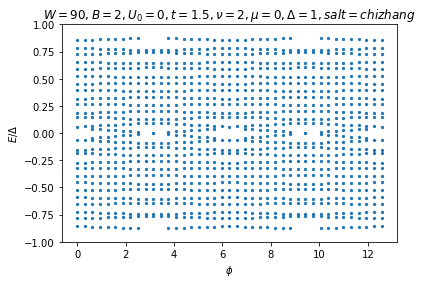

In [75]:
phi_plot(e_array24, 'trial e-phi', title=r'$W=90, B=2, U_0=0, t=1.5, \nu=2, \mu=0, \Delta=1, salt=chizhang$')

In [48]:
E_M45 = [[complicated_e_phi1[0][i][int(len(complicated_e_phi1[0][i])/2-1)], complicated_e_phi1[0][i][int(len(complicated_e_phi1[0][i])/2)]] for i in range(len(complicated_e_phi1[0]))]
print(E_M45)

[[-0.06291454530538985, 0.06291454530538947], [-0.06166821319212281, 0.06166821319212283], [-0.058184193346249344, 0.05818419334624906], [-0.053022117659788266, 0.05302211765978804], [-0.04672523563744819, 0.04672523563744845], [-0.03968964946251115, 0.03968964946251094], [-0.03217564903231441, 0.03217564903231358], [-0.02435177784944237, 0.024351777849443097], [-0.016330716367077003, 0.016330716367076493], [-0.008192649729208386, 0.008192649729207795], [6.42715047849407e-16, 6.42715047849407e-16], [-0.008192649729208449, 0.008192649729208298], [-0.01633071636707704, 0.016330716367076416], [-0.024351777849442435, 0.02435177784944311], [-0.03217564903231426, 0.03217564903231352], [-0.03968964946251101, 0.03968964946251065], [-0.046725235637448764, 0.04672523563744862], [-0.053022117659788336, 0.05302211765978777], [-0.05818419334624896, 0.058184193346251266], [-0.061668213192122935, 0.06166821319212283], [-0.06291454530538985, 0.06291454530538947], [-0.06166821319212303, 0.0616682131921

In [59]:
print(complicated_e_phi1[0][8])
print(complicated_e_phi1[0][9])
print(complicated_e_phi1[0][10])

[-0.87296512 -0.68836408 -0.64360594 -0.43201566 -0.40451488 -0.19872515
 -0.17009639 -0.01633072  0.01633072  0.17009639  0.19872515  0.40451488
  0.43201566  0.64360594  0.68836408  0.87296512]
[-0.87500087 -0.68541448 -0.64643385 -0.42720891 -0.40938116 -0.19188638
 -0.00819265  0.00819265  0.19188638  0.40938116  0.42720891  0.64643385
  0.68541448  0.87500087]
[-8.75711277e-01 -6.84304229e-01 -6.47502985e-01 -4.11822750e-01
 -1.85074742e-01  6.42715048e-16  6.42715048e-16  1.85074742e-01
  4.11822750e-01  6.47502985e-01  6.84304229e-01  8.75711277e-01]


[5.912710578738126, 5.912717773057773, 5.978257421628238, 5.982713172054549, 5.987315407745057, 5.9919100845278415, 5.996420334091891, 6.000788140025421, 6.004942875103345, 5.0380265075323045, 5.129913343166634, 5.038026507532305, 6.004942875103345, 6.000788140025421, 5.996420334091891, 5.9919100845278415, 5.987315407745057, 5.982713172054549, 5.978257421628238, 5.912717773057773, 5.912710578738126, 5.912717773057772, 5.978257421628238, 5.982713172054548, 5.987315407745057, 5.9919100845278415, 5.996420334091891, 6.000788140025421, 6.004942875103345, 5.038026507532305, 5.129913343166634, 5.0380265075323045, 6.004942875103345, 6.000788140025422, 5.996420334091891, 5.9919100845278415, 5.987315407745057, 5.982713172054548, 5.978257421628239, 5.912717773057772, 5.912710578738126]


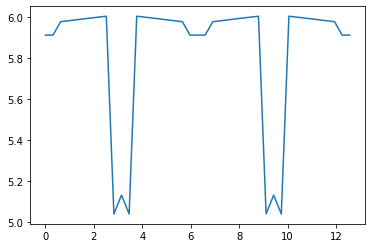

In [76]:
E_J45 = [ground_state_energy(e_array24[i]) for i in range(len(e_array24))]
print(E_J45)
plt.plot(np.linspace(0, 4*np.pi, 41), E_J45)

0
[-0.82484417 -0.29299719  0.29299719  0.82484417]
[-8.49527471e-01  6.43582410e-16  6.43582410e-16  8.49527471e-01]
1
[-0.66311949 -0.13188976  0.13188976  0.66311949]
[-6.25852983e-01  6.60062283e-16  6.60062283e-16  6.25852983e-01]
2
[-0.71041241 -0.3928608   0.3928608   0.71041241]
[-8.77686763e-01  2.91925934e-09  2.91925934e-09  8.77686763e-01]
3
[-0.4038505  -0.11468791  0.11468791  0.4038505 ]
[-4.7802542e-01  6.6353173e-16  6.6353173e-16  4.7802542e-01]
4
[-0.50601904 -0.04231066  0.04231066  0.50601904]
[-5.86997485e-01  6.59194921e-16  6.59194921e-16  5.86997485e-01]
5
[-0.4744818  -0.18080397  0.18080397  0.4744818 ]
[-5.64473338e-01  6.07349057e-09  6.07349057e-09  5.64473338e-01]
7
[-0.81278036 -0.45317019 -0.08892865  0.08892865  0.45317019  0.81278036]
[-6.88141169e-01 -5.54507201e-01  6.53990750e-16  6.53990750e-16
  5.54507201e-01  6.88141169e-01]
8
[-0.87859587 -0.31684994 -0.14175345  0.14175345  0.31684994  0.87859587]
[-7.91202718e-01 -3.85725321e-01 -7.87697319e

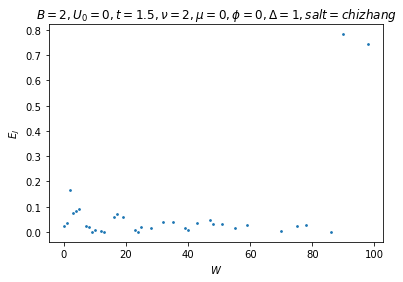

In [73]:
EJ_plot(e_array21, e_array22, gap_energy, 'E_J vs W, corrected')

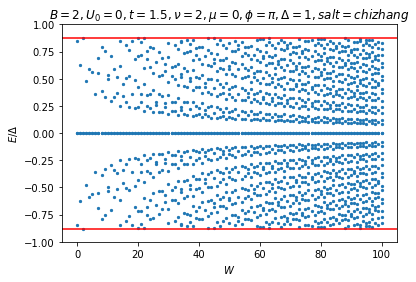

In [12]:
W_plot(e_array22, 'W_scan_total_pi_phase', gap_energy, title=r'$B=2, U_0=0, t=1.5, \nu=2, \mu=0, \phi=\pi, \Delta=1, salt=chizhang$')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
[0.29299719 0.13188976 0.3928608  0.11468791 0.04231066 0.18080397
 0.22595203 0.08892865 0.14175345 0.1499279  0.0966444  0.14520291
 0.11443911 0.09886145 0.15995481 0.09689097 0.10337373 0.12185425
 0.08858625 0.11139123 0.09946694 0.08600751 0.12229636 0.08622295
 0.0875987  0.10776021 0.07901797 0.09250303 0.08987118 0.07610842
 0.0999629  0.07851506 0.0765144  0.10899688 0.07185457 0.07962201
 0.08240839 0.0687034  0.08489574 0.07242591 0.06832271 0.09166569
 0.06620318 0.07022496 0.07639015 0.06291455 0.0739984  0.06746625
 0.06199355 0.07915482 0.06161345 0.06304487 0.071390

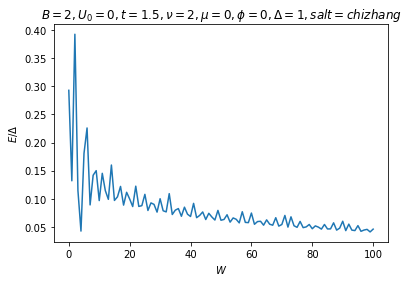

In [69]:
W_plot_lowest_mode(e_array21, 'W_scan_real', W_range=[0, 101])

exponent:
-0.012117481630335308+-0.0007961464537710515
[0.85594321 0.49931236 1.         0.44690432 0.         0.66441532
 0.77104303 0.35348623 0.57051578 0.60144911 0.40772697 0.5979161
 0.49539649 0.43450949 0.65830659 0.43637044 0.47125052 0.55136746
 0.41220855 0.52163215 0.47576216 0.41529832 0.58049805 0.4274283
 0.44010751 0.53958199 0.40433192 0.4813145  0.47371684 0.40380388
 0.53299363 0.42892274 0.42270999 0.58873886 0.40519788 0.4572643
 0.47836701 0.40134474 0.50285306 0.43627852 0.41531632 0.55415403
 0.41201408 0.44426771 0.48794264 0.40539093 0.48450585 0.44807572
 0.41519294 0.53155943 0.42339769 0.43931472 0.50121399 0.41444749
 0.47478861 0.46333065 0.42066377 0.56166603 0.43839994 0.4405466
 0.56407096 0.42749998 0.47172586 0.48134275 0.43060269 0.5110191
 0.45633702 0.44672014 0.5545595  0.44381984 0.47399103 0.59795837
 0.44420747 0.59259355 0.47669291 0.4569546  0.5505905  0.46285943
 0.48064392 0.52365811 0.46087988 0.51305087 0.49906389 0.47059751
 0.55122782 

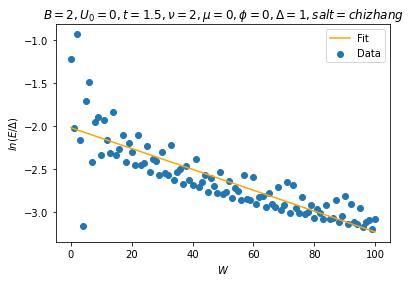

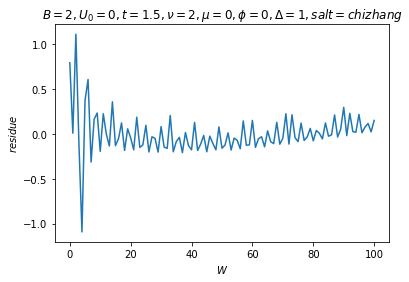

In [72]:
W_plot_semilog(e_array21, 'W_semilog_scan_real', W_range=[0, 101], fit=True)

In [ ]:
e_array8, psi_array8 = W_scan(mu=2.)

In [ ]:
e_array9, psi_array9 = W_scan(mu=5., W_array=[0, 21])

In [ ]:
e_array10, psi_array10 = W_scan(mu=-0.9, W_array=[0, 101], B=2.*np.sqrt(0.9**2.+1.**2.))

In [ ]:
e_array11, psi_array11 = W_scan(mu=-2., W_array=[0, 101], B=1.61)

In [ ]:
e_array13, psi_array13 = W_scan(W_array=[0, 101], B=1.4, t=50., nu=2., mu=0., U_0=0., delta=1., phi=0., salt='chizhang')

In [ ]:
e_array14, psi_array14 = W_scan(W_array=[0, 101], B=0., t=50., nu=2., mu=0., U_0=0., delta=1., phi=0., salt='chizhang')

In [ ]:
import pickle
e_array21 = pickle.load(open('./Keselman5/Data/e_array21', 'rb'))
print(e_array21)

In [ ]:
e_array21, psi_array21 = W_scan(W_array=[0, 101], B=2., t=1.5, nu=2., mu=0., U_0=0., delta=1., phi=0., salt='chizhang')

In [ ]:
e_array22, psi_array22 = W_scan(W_array=[0, 101], B=2., t=1.5, nu=2., mu=0., U_0=0., delta=1., phi=np.pi, salt='chizhang')

In [65]:
pickle.dump(complicated_e_phi1, open('./Keselman5/Data/complicated_e_phi1', 'wb'))

In [ ]:
e_array23, psi_array23 = phi_scan(W=22)

In [74]:
e_array24, psi_array24 = phi_scan(W=90)

0.0
[-0.85854462 -0.77950299 -0.72809444 -0.6518119  -0.59178954 -0.52465148
 -0.45398275 -0.39755843 -0.31749811 -0.27190851 -0.18501094 -0.15235687
 -0.05986211  0.05986211  0.15235687  0.18501094  0.27190851  0.31749811
  0.39755843  0.45398275  0.52465148  0.59178954  0.6518119   0.72809444
  0.77950299  0.85854462]
0.3141592653589793
[-0.8588845  -0.77918882 -0.72839943 -0.65155061 -0.59205719 -0.52441045
 -0.45424948 -0.39729647 -0.31782938 -0.27155335 -0.18558751 -0.15171059
 -0.06167626  0.06167626  0.15171059  0.18558751  0.27155335  0.31782938
  0.39729647  0.45424948  0.52441045  0.59205719  0.65155061  0.72839943
  0.77918882  0.8588845 ]
0.6283185307179586
[-0.859885   -0.77826766 -0.7292946  -0.65078898 -0.59283651 -0.52371138
 -0.45502017 -0.39654018 -0.31877556 -0.27053587 -0.18717545 -0.14991179
 -0.06551427 -0.04136376  0.04136376  0.06551427  0.14991179  0.18717545
  0.27053587  0.31877556  0.39654018  0.45502017  0.52371138  0.59283651
  0.65078898  0.7292946   0.77

In [44]:
complicated_e_phi1 = []
W_list1 = [45, 49, 53, 57, 61]

for i in W_list1:
    e_array_temp, _ = phi_scan(W=i)
    complicated_e_phi1.append(e_array_temp)
print(complicated_e_phi1)

0.0
[-0.85068994 -0.71404198 -0.61988531 -0.45942127 -0.37612918 -0.2306944
 -0.12587095 -0.06291455  0.06291455  0.12587095  0.2306944   0.37612918
  0.45942127  0.61988531  0.71404198  0.85068994]
0.3141592653589793
[-0.85124166 -0.71345854 -0.62040278 -0.45888077 -0.37670322 -0.23008119
 -0.12708569 -0.06166821  0.06166821  0.12708569  0.23008119  0.37670322
  0.45888077  0.62040278  0.71345854  0.85124166]
0.6283185307179586
[-0.85285005 -0.7117507  -0.62192432 -0.45728605 -0.37839252 -0.22827244
 -0.13047399 -0.05818419  0.05818419  0.13047399  0.22827244  0.37839252
  0.45728605  0.62192432  0.7117507   0.85285005]
0.9424777960769379
[-0.8553821  -0.70903828 -0.62436091 -0.45471301 -0.3811052  -0.22535389
 -0.1354734  -0.05302212  0.05302212  0.1354734   0.22535389  0.3811052
  0.45471301  0.62436091  0.70903828  0.8553821 ]
1.2566370614359172
[-0.85863516 -0.70550072 -0.62757335 -0.45127545 -0.38470661 -0.22144878
 -0.14153583 -0.04672524  0.04672524  0.14153583  0.22144878  0.3

In [24]:
def ground_state_energy(array):
    return -(np.sum(array[0:int(len(array)/2)]) - array[int(len(array)/2-1)])

ground_state_energy(e_array22[-1])

6.272204625788972

# E_M vs mu_leads

In [30]:
trial_array=pickle.load(open('./Keselman5/Data/Keselman_vary_chempot_leads_shortjunc','rb'))
print(trial_array[0])

[array([-0.31904245,  0.31904245]), array([-0.30191813,  0.30191813]), array([-0.28567388,  0.28567388]), array([-0.27007746,  0.27007746]), array([-0.25486129,  0.25486129]), array([-0.23972575,  0.23972575]), array([-0.22434294,  0.22434294]), array([-0.20836056,  0.20836056]), array([-0.19140609,  0.19140609]), array([-0.17309143,  0.17309143]), array([-0.15301874,  0.15301874]), array([-0.13078853,  0.13078853]), array([-0.10601183,  0.10601183]), array([-0.07832913,  0.07832913]), array([-0.04744007,  0.04744007]), array([-0.01314997,  0.01314997]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.23761224,  0.23761224]), array([-0.27235314,  0.27235314]), array([-0.29929521,  0.29929521]), array([-0.31755617,  0.31755617]), array([-0.32735585,  0.32735585]), array([-0.32961796,  0.32961796]), array([-0.32552195,  0.32552195]), array([-0.31621196,  0.31621196]), array([-0.3026723,  0.3026723

In [37]:
def mu_leads_gap_plot(energy_array, e_gap_array, figure_title, mu_leads_range=[-2.5, 2.5], delta=1., title=r'$W=0, B=2, U_0=0, t=1.5, \nu=2, \mu_{scat}=0, \phi=0, \Delta=1, salt=chizhang$'):
    ex=[]
    ey=[]
    mu_array = np.linspace(mu_leads_range[0], mu_leads_range[1], 101)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(mu_array[i])
            ey.append(energy_array[i][j])
        
    ex = np.array(ex)
    ey = np.array(ey)/delta
    plt.plot(mu_array, e_gap_array/delta)
    plt.scatter(ex, ey, s=3)
    #plt.xlim(B_range[0], B_range[1])
    plt.xlabel(r'$\mu_{leads}$')
    plt.ylabel(r'$E/\Delta$')
    plt.title(title)
    plt.savefig('./Keselman5/'+figure_title, dpi=300)

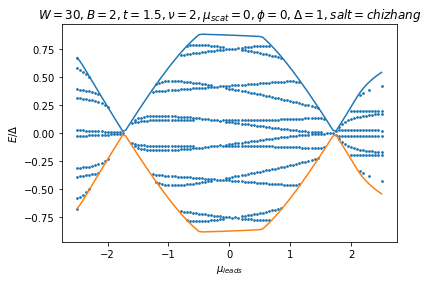

In [46]:
mu_leads_gap_plot(trial_array[7], e_mu_gap1, 'mu_lead_plot(W=30)', title=r'$W=30, B=2, t=1.5, \nu=2, \mu_{scat}=0, \phi=0, \Delta=1, salt=chizhang$')

In [33]:
def mu_leads_gap_scan(W=0, B=2., t=1.5, nu=2., mu_array=[-2.5, 2.5], delta=1., U_0=0., phi=0., salt='chizhang', mode='gauss'):
    band_gap_array = []
    for i in np.linspace(mu_array[0], mu_array[1], 101):
        print(i)
        syst = make_system_disorder(W=W, B=B, t=t, nu=nu, mu=i, U_0=U_0, delta=delta, phi=phi, salt=salt)
        bands=kwant.physics.Bands(syst.leads[1])
        momenta=np.linspace(-np.pi,np.pi,100001)
        energies=[bands(k) for k in momenta]
        x=np.array(energies)
        en=(x)
        band_gap_array.append([np.min(en[:,2]), np.max(en[:,1])])
        print(np.min(en[:,2]))
    return np.array(band_gap_array)

In [34]:
e_mu_gap1 = mu_leads_gap_scan()

-2.5
0.6773232046899386
-2.45
0.6412267430145892
-2.4
0.5998323516801756
-2.35
0.5539185578244259
-2.3
0.50798724079689
-2.25
0.4622144504490261
-2.2
0.41660919471891356
-2.15
0.371181140275875
-2.1
0.32594066992260107
-2.05
0.28089894559140827
-2.0
0.2360679774997894
-1.95
0.19146070008111185
-1.9
0.14709105535838837
-1.85
0.10297408448130857
-1.7999999999999998
0.05912602819739897
-1.75
0.015564437074637448
-1.7
0.027691707668397705
-1.65
0.07062186184252577
-1.6
0.11320377358867963
-1.5499999999999998
0.1554133254303289
-1.5
0.1972243622680055
-1.45
0.23860850461914623
-1.4
0.27953494659147415
-1.3499999999999999
0.319970238358856
-1.2999999999999998
0.3598780533143279
-1.25
0.3992189406417874
-1.2
0.4379500648186689
-1.15
0.4760249345871825
-1.0999999999999999
0.51339312526815
-1.0499999999999998
0.55
-1.0
0.5857864376269053
-0.95
0.6206885775866277
-0.8999999999999999
0.6546375952926291
-0.8499999999999999
0.6875595251593316
-0.7999999999999998
0.71937515251343
-0.75
0.75
-0.7
0.7

# E_M vs delta in short finite junction limite
## expect to see BS solns match up with spectral gap as we go to smaller and smaller delta

In [ ]:
e_array15, psi_array15 = delta_scan()

In [ ]:
eB1 = [e_array15[i][0] for i in range(len(e_array15))]
eB2 = [e_array15[i][1] for i in range(len(e_array15))]
eB3 = [e_array15[i][2] for i in range(len(e_array15))]
print(eB1)
print(eB2)
print(eB3)

In [ ]:
e_delta_gap = delta_gap_scan()

AttributeError: 'PathCollection' object has no property 'markersize'

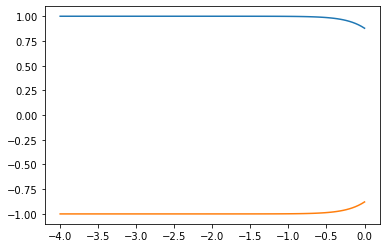

In [82]:
delta_gap_plot(eB2, e_delta_gap[1], 'delta_gap_scan(B=2Bc, W=1)', title=r'$W=1, U_0=0, t=1.5, \nu=2, \mu=0, \phi=0, B=2B_C, salt=chizhang$')

In [72]:
e_delta_gap[1,:,0]

array([9.20733331e-05, 1.00189891e-04, 1.09152035e-04, 1.19036961e-04,
       1.29929456e-04, 1.41922665e-04, 1.55118925e-04, 1.69630666e-04,
       1.85581391e-04, 2.03106747e-04, 2.22355690e-04, 2.43491768e-04,
       2.66694512e-04, 2.92160974e-04, 3.20107401e-04, 3.50771081e-04,
       3.84412353e-04, 4.21316828e-04, 4.61797811e-04, 5.06198961e-04,
       5.54897213e-04, 6.08305979e-04, 6.66878654e-04, 7.31112469e-04,
       8.01552710e-04, 8.78797352e-04, 9.63502128e-04, 1.05638610e-03,
       1.15823777e-03, 1.26992176e-03, 1.39238616e-03, 1.52667057e-03,
       1.67391493e-03, 1.83536923e-03, 2.01240403e-03, 2.20652221e-03,
       2.41937163e-03, 2.65275918e-03, 2.90866610e-03, 3.18926479e-03,
       3.49693726e-03, 3.83429536e-03, 4.20420293e-03, 4.60980014e-03,
       5.05453010e-03, 5.54216815e-03, 6.07685388e-03, 6.66312624e-03,
       7.30596213e-03, 8.01081861e-03, 8.78367923e-03, 9.63110485e-03,
       1.05602893e-02, 1.15791205e-02, 1.26962473e-02, 1.39211530e-02,
      

In [76]:
np.array([eB2[i][-1] for i in range(len(eB2))])

array([9.72026940e-05, 1.06580417e-04, 1.16862843e-04, 1.28137245e-04,
       1.40499318e-04, 1.54053985e-04, 1.68916289e-04, 1.85212372e-04,
       2.03080539e-04, 2.22672434e-04, 2.44154328e-04, 2.67708526e-04,
       2.93534913e-04, 3.21852648e-04, 3.52902027e-04, 3.86946511e-04,
       4.24274964e-04, 4.65204101e-04, 5.10081168e-04, 5.59286883e-04,
       6.13238661e-04, 6.72394149e-04, 7.37255094e-04, 8.08371592e-04,
       8.86346737e-04, 9.71841725e-04, 1.06558143e-03, 1.16836055e-03,
       1.28105028e-03, 1.40460570e-03, 1.54007380e-03, 1.68860234e-03,
       1.85144945e-03, 2.02999430e-03, 2.22574862e-03, 2.44036944e-03,
       2.67567298e-03, 2.93364986e-03, 3.21648177e-03, 3.52655966e-03,
       3.86650375e-03, 4.23918527e-03, 4.64775037e-03, 5.09564616e-03,
       5.58664923e-03, 6.12489676e-03, 6.71492051e-03, 7.36168395e-03,
       8.07062266e-03, 8.84768845e-03, 9.69939743e-03, 1.06328822e-02,
       1.16559486e-02, 1.27771375e-02, 1.40057918e-02, 1.53521281e-02,
      